# Exercise 01 - Simulation of the 1d-Ising-model

The one-dimensional Ising-model is studied via a Monte-Carlo-Simulation and the results will be compared to analytically calculated solutions.

## Theory

Consider a 1-dimensional chain of spins with length $N$ $\mathbf{s_N}=(\uparrow,\downarrow,\downarrow,\uparrow,\dots)$ where each spin can take the value $s_n=\pm 1$. This chain of spins lies in a heat bath with temperature $T$ and is exposed to an external magnetic field of strength $h$. Following this the Hamiltonian is given as 

$$\mathcal{H}(s)=-J\sum_{\langle x,y\rangle}s_xs_y-h\sum_{x}s_x. $$
1. *Discuss the physical meaning of J, in particular the sign of J, and the role it plays in magnets, for example.*

Here $J$ describes the strength of the spin-spin-coupling. For $J<0$ $\mathcal{H}(s)$ describes a repulsive potential between the spins (antiferromagnetic) $J>0$ $\mathcal{H}(s)$ describes an attractive potential (ferromagnetic). Trivially for $J=0$ no interaction between spins take place.

2. *Clarify what it means to have periodic boundary conditions (nearest neighbors).* 

To simulate an *infinite* chain of spins one employs periodic boundary conditions, which means that each element of the chain $s_n$ has the nearest neighbors $s_{n-1}$ and $s_{n+1}$ regardless of the actual position in the chain. That means if $n=N$ ($n=0$) the nearest neighbors are $[N-1,0]$ ($[N,1]$). 

The probability of finding a specific spin configuration $\mathbf{s_N}$ is given by 

$$\mathbf{P}(\mathbf{s})=\exp{\bigg(-\frac{\mathcal{H}(\mathbf{s})}{k_bT}\bigg)}/\sum_{\mathbf{s'}}\exp{\bigg(-\frac{\mathcal{H}(\mathbf{s'})}{k_bT}\bigg)}:=\frac{1}{Z}\exp{\bigg(-\frac{\mathcal{H}(\mathbf{s'})}{k_bT}\bigg)}$$

with the partition function $Z:=\sum_{\mathbf{s'}}\exp{\left(\frac{-\mathcal{H}(\mathbf{s'})}{k_BT}\right)}$ which can be calculated analytically (see e.g. [this wikipedia-article](https://en.wikipedia.org/wiki/Ising_model#Ising's_exact_solution) ) to be 
$$Z=\lambda_+^N+\lambda_-^N ; \lambda_\pm=e^{\frac{J}{T}}\bigg(\cosh\big(\frac{h}{T}\big)\pm\sqrt{\sinh\big(\frac{h}{T}\big)^2+e^{-4\frac{J}{T}}}\bigg)$$
where we set $k_B=1$.

*Since we work with units where $k_B=1$, what are the relevant dimensionless ratios in the problem?*

This leads to $\frac{J}{T}$ and $\frac{h}{T}$ to be dimensionless.

With the partition function one can calculate the magnetization per spin $$\begin{equation} \langle m \rangle = \frac{T}{N}\frac{\partial\log Z}{\partial h }=\frac{1-(\lambda_-^N/\lambda_+^N)}{1+(\lambda_-^N/\lambda_+^N)}\frac{\left(\sinh{\frac{h}{T}}\right)}{\sqrt{\sinh{\frac{h}{T}}^2+e^{-4J/T}}}\overset{N\to\infty}{=}\frac{\left(\sinh{\frac{h}{T}}\right)}{\sqrt{\sinh{\frac{h}{T}}^2+e^{-4J/T}}} \label{eq:eq1}\end{equation} \tag{1}$$
## Aim of the code




3. *Implement the Ising 1d simulation: determine an estimate for magnetization per spin* $$\langle m\rangle=\frac{T}{N}\frac{\partial \log{Z}}{\partial h}$$ *and estimate the error of your estimate.*

Below the implementation for an estimate of the magnetization per spin $\langle m \rangle$ can be found. We divided it into two parts, the numerical approach, where we use a Monte-Carlo-Simulation to get a result and the analytical approach where we simply implemented equation (1) in python code.

### Numerical approach
To numerically estimate the magnetizazion per spin we used the Monte-Carlo-Method. We randomly created an ensemble $\mathbf{S}$ with random spin configurations $\mathbf{s}$ with `ensemble_length` spin configurations. Then the expectation value can be estimated via $$\langle m\rangle=\frac{\sum_{\mathbf{s} \in\{\mathbf{S}\}} O(\mathbf{s}) e^{-\beta \mathcal{H}(\mathbf{s})}}{\sum_{\mathbf{s} \in\{\mathbf{S}\}} e^{-\beta \mathcal{H}(\mathbf{s})}}.$$
To estimate an error of the estimate we calculate $\langle m\rangle$ several times and compute the expectation value $\mu$ and variance $\sigma$ of the resulting distribution of $\langle m_i\rangle$.

[array([1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1])]


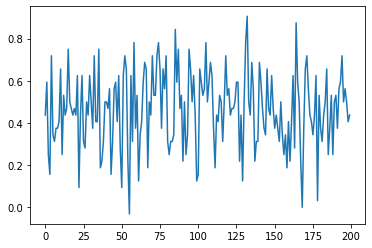

In [1]:
# Import packages
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


# A method to set the plot parameters and make them beautiful ;)
def beauty_plot():
    plt.figure(figsize=(10,5))
    plt.minorticks_on()
    plt.rcParams["mathtext.fontset"]="cm"
    plt.rcParams['errorbar.capsize'] = 3
    plt.rcParams['mathtext.rm'] = 'serif'
    font={'family' : 'serif','size'   : 22}
    plt.rc("font",**font)
    plt.xticks(fontsize=22,fontname='DejaVu Serif')
    plt.yticks(fontsize=22,fontname='DejaVu Serif')
    plt.grid(color='black',linestyle=':')

def find_neighbors(s, i, j):
    # find nearest neighbors
    #left = s[j][i-1]
    #top = s[j-1][i]
    try:
        bottom = s[j+1][i]
    except: 
        bottom = s[0][i]
    try:
        right = s[j][i+1]
    except:
        right = s[j][0]
    
    return right, bottom
        
        
# Define the Hamiltonian
def Hamiltonian(s,h):
    neighbor_sum = 0
    spin_sum = 0 
    for i in range(0,N_x):
        for j in range(0, N_y):
            neighbors = find_neighbors(s, i, j)
            for z in neighbors:
                neighbor_sum += s[j][i]*z
            spin_sum += s[j][i]
            
    return -J*neighbor_sum-h*spin_sum


# Methode to create spin configurations
def Two_D_spin_config(N_x, N_y):
    spin_config = []
    for i in range(0, N_y):
        spin_config.append(2*np.random.randint(0,2,size=N_x)-1)
    return spin_config

def Metropolis(s, N_x, N_y):
    s_mod = s
    for i in range(0, N_x):
            for j in range(0, N_y):
                # Calculate the unflipped Hamiltonian 
                hamiltonian_natural = Hamiltonian(s_mod, h)
                # Flip the current spin and calculate the Hamiltonian
                s_mod[j][i] *= -1
                hamiltonian_flipped = Hamiltonian(s_mod, h)
                # Metropolis-Hastings-step (Accept if Uniform{0,1} < exp(Delta S) with Delta S = "Difference of flipped and unflipped Hamiltonian")
                if np.exp(-beta*(hamiltonian_flipped-hamiltonian_natural))<np.random.uniform(0,1):
                    # Reject otherwise
                    s_mod[j][i] *= -1

                    
    # Return modified spin configuration
    return s_mod, np.sum(s_mod)/N_x/N_y

#Calculate the expectation value
def numerical(N_x,N_y,h):
    
    ensamble = []   
    x = []
    y = []
    for z in range(0, sample_size):
        spin_config = Two_D_spin_config(N_x, N_y)
        print(spin_config)
        test = spin_config.copy()
        for i in range(0,200):
            spin_config, mag = Metropolis(spin_config, N_x, N_y)
            test = spin_config.copy()
            y.append(mag)
            x.append(i)
        
    plt.plot(x,y)
        
                            
                    
# s[N_y][N_x] - N_y: Zeile, N_x: Spalte
T = 5
beta = 1/T
h=1
J=1
sample_size = 1
N_x = 8
N_y = N_x
numerical(N_x,N_y,1)


### Analytical approach
To compare the numerical resolutions with the analytical ones, the following code represents the shown equations

In [2]:
##this is just implemented what was stated in the theory section
def lamda(sign, h):
    return np.exp(J/T)*(np.cosh(h/T)+sign*np.sqrt(np.sinh(h/T)**2+np.exp(-4*J/T)))
    

def analytical(inf, N, h):
    if inf == True:
        return np.sinh(h/T)/(np.sqrt(np.sinh(h/T)**2+np.exp(-4*J/T)))
    else:
        return (1-(lamda(-1, h)**N/lamda(1, h)**N))/(1+(lamda(-1, h)**N/lamda(1, h)**N))*(np.sinh(h/T))/(np.sqrt(np.sinh(h/T)**2+np.exp(-4*J/T)))

